In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import math
import requests
from bs4 import BeautifulSoup
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
pd.set_option("display.max_columns",100)

from helper_functions.functions import Helpers
from joblib import dump
from joblib import load

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

grounds = np.load('grounds.npy')
grounds = np.append(grounds, 'other')
enc.fit(pd.DataFrame(grounds))
# dump(enc, 'models/enc.joblib') 

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [19]:
enc = load('models/enc.joblib')

In [42]:
## Proxy settings when using cntlm
http_proxy  = "http://localhost:3128"
https_proxy = "https://localhost:3128"

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy, 
            }
proxyDict = None

In [21]:
mapping = {
    'Richmond': 'richmond',
    'West Coast': 'westcoast',
    'Sydney': 'swans',
    'Adelaide': 'adelaide',
    'Geelong': 'geelong',
    'Greater Western Sydney': 'gws',
    'Melbourne': 'melbourne',
    'Port Adelaide': 'padelaide',
    'Collingwood': 'collingwood',
    'Hawthorn': 'hawthorn',
    'Essendon': 'essendon',
    'Western Bulldogs': 'bullldogs',
    'St Kilda': 'stkilda',
    'North Melbourne': 'kangaroos',
    'Kangaroos' : 'kangaroos',
    'Fremantle': 'fremantle',
    'Brisbane Lions': 'brisbanel',
    'Gold Coast': 'goldcoast',
    'Carlton': 'carlton'
}
teams = list(mapping.keys())

In [108]:
from data_prep.team_history import History
team_df = History(mapping, proxyDict, enc).generate_team_history(season_list=range(16))
# team_df = History(mapping, proxyDict, enc).generate_team_history(season_list=[0]) # current season

Richmond 0
Richmond 1
Richmond 2
Richmond 3
Richmond 4
Richmond 5
Richmond 6
Richmond 7
Richmond 8
Richmond 9
Richmond 10
Richmond 11
Richmond 12
Richmond 13
Richmond 14
Richmond 15
West Coast 0
West Coast 1
West Coast 2
West Coast 3
West Coast 4
West Coast 5
West Coast 6
West Coast 7
West Coast 8
West Coast 9
West Coast 10
West Coast 11
West Coast 12
West Coast 13
West Coast 14
West Coast 15
Sydney 0
Sydney 1
Sydney 2
Sydney 3
Sydney 4
Sydney 5
Sydney 6
Sydney 7
Sydney 8
Sydney 9
Sydney 10
Sydney 11
Sydney 12
Sydney 13
Sydney 14
Sydney 15
Adelaide 0
Adelaide 1
Adelaide 2
Adelaide 3
Adelaide 4
Adelaide 5
Adelaide 6
Adelaide 7
Adelaide 8
Adelaide 9
Adelaide 10
Adelaide 11
Adelaide 12
Adelaide 13
Adelaide 14
Adelaide 15
Geelong 0
Geelong 1
Geelong 2
Geelong 3
Geelong 4
Geelong 5
Geelong 6
Geelong 7
Geelong 8
Geelong 9
Geelong 10
Geelong 11
Geelong 12
Geelong 13
Geelong 14
Geelong 15
Greater Western Sydney 0
Greater Western Sydney 1
Greater Western Sydney 2
Greater Western Sydney 3
Greate

In [411]:
from data_prep.team_history import History
History(mapping, proxyDict, enc).generate_game_data('training-all/', team_df,season_list=range(16))
# History(mapping, proxyDict, enc).generate_game_data('training-all/', team_df, season_list=[0]) # current season

2019 Richmond
2019 West Coast
2019 Sydney
2019 Adelaide
2019 Geelong
2019 Greater Western Sydney
2019 Melbourne
2019 Port Adelaide
2019 Collingwood
2019 Hawthorn
2019 Essendon
2019 Western Bulldogs
2019 St Kilda
2019 North Melbourne
2019 Fremantle
2019 Brisbane Lions
2019 Gold Coast
2019 Carlton
2018 Richmond
2018 West Coast
2018 Sydney
2018 Adelaide
2018 Geelong
2018 Greater Western Sydney
2018 Melbourne
2018 Port Adelaide
2018 Collingwood
2018 Hawthorn
2018 Essendon
2018 Western Bulldogs
2018 St Kilda
2018 North Melbourne
2018 Fremantle
2018 Brisbane Lions
2018 Gold Coast
2018 Carlton
2017 Richmond
2017 West Coast
2017 Sydney
2017 Adelaide
2017 Geelong
2017 Greater Western Sydney
2017 Melbourne
2017 Port Adelaide
2017 Collingwood
2017 Hawthorn
2017 Essendon
2017 Western Bulldogs
2017 St Kilda
2017 North Melbourne
2017 Fremantle
2017 Brisbane Lions
2017 Gold Coast
2017 Carlton
2016 Richmond
2016 West Coast
2016 Sydney
2016 Adelaide
2016 Geelong
2016 Greater Western Sydney
2016 Melbour

In [22]:
X_list = []
y_list = []
rnd = 1 #Filter out rounds before this number

## Easy seasons 11, 12, 13, 16 [8,7,6,3]
for i in range(0,12):
    X = np.load('training-all/training-'+str(2019-i)+'.npy')

    mask = np.isnan(X).any(axis=1)
    index = np.where(mask==True)[0][0] ## X8 has a row containing nulls
    X = np.delete(X, index, 0)
    mask2 = np.array([(row[0] >= rnd) for row in X])
    X_list.append(X[mask2])

    y = np.load('training-all/results-'+str(2019-i)+'.npy')
    y = np.delete(y, index, 0)
    y_list.append(y[mask2])
    
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(X.shape)
print(y.shape)

print('Wins vs losses',np.sum(y)/float(len(y)))

(2193, 18)
(2193,)
Wins vs losses 0.5699954400364797


In [87]:
from data_prep.feature_eng import Features
cols = Features().cols()
df = Features().div_cols(X)
df.head()

,Rnd,h_F_mean,h_F_std,h_A_mean,h_A_std,h_M_mean,h_M_std,h_R_mean,h_perc,a_F_mean,a_F_std,a_A_mean,a_A_std,a_M_mean,a_M_std,a_R_mean,a_perc,grnd,perc,R_mean,F_ph_na,F_ph_pa,F_nh_na,F_nh_pa,A_nh_pa,A_nh_na,A_ph_pa,A_ph_na
0,2.0,97.000000,0.000000,64.000000,0.000000,33.000000,0.000000,1.000000,1.515625,65.000000,0.000000,72.000000,0.000000,-7.000000,0.000000,0.000000,0.902778,23.0,1.678846,0.00,1.492308,1.492308,1.492308,1.492308,0.888889,0.888889,0.888889,0.888889
1,5.0,84.500000,13.973189,97.750000,22.719760,-13.250000,22.719760,0.500000,0.864450,74.500000,12.257651,86.000000,9.486833,-11.500000,9.486833,0.250000,0.866279,32.0,0.997889,2.00,1.582093,1.135038,1.133100,0.812917,0.785765,0.980619,1.261637,1.574497
2,6.0,85.400000,12.626955,91.600000,23.753737,-6.200000,23.753737,0.600000,0.932314,74.800000,26.194656,103.200000,20.989521,-28.400000,20.989521,0.200000,0.724806,23.0,1.286295,3.00,2.016794,0.970615,1.497223,0.720563,0.546312,0.825275,0.928852,1.403151
3,9.0,84.375000,17.888107,85.625000,25.203856,-1.250000,25.203856,0.625000,0.985401,82.250000,8.757140,78.000000,23.194827,4.250000,23.194827,0.500000,1.054487,23.0,0.934484,1.25,1.391470,1.123682,0.904671,0.730568,0.597077,1.102472,1.095203,2.022233
4,10.0,85.555556,17.192447,82.666667,25.192592,2.888889,25.192592,0.666667,1.034946,79.777778,29.637730,79.111111,19.969112,0.666667,19.969112,0.444444,1.008427,12.0,1.026298,1.50,2.049220,0.939063,1.363443,0.624803,0.580076,0.971798,1.088605,1.823734


In [88]:
df.describe()

,Rnd,h_F_mean,h_F_std,h_A_mean,h_A_std,h_M_mean,h_M_std,h_R_mean,h_perc,a_F_mean,a_F_std,a_A_mean,a_A_std,a_M_mean,a_M_std,a_R_mean,a_perc,grnd,perc,R_mean,F_ph_na,F_ph_pa,F_nh_na,F_nh_pa,A_nh_pa,A_nh_na,A_ph_pa,A_ph_na
count,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000
mean,11.718650,86.360201,20.152312,86.994347,20.207982,-0.634146,20.207982,0.476196,0.988898,86.981431,20.026499,86.472487,20.049022,0.508944,20.049022,0.488300,1.003812,21.940264,1.022584,1.096276,1.605425,0.977967,0.988777,0.612035,0.622290,1.005811,0.988771,1.626491
std,6.649372,23.597344,9.154567,23.841842,8.848035,25.414942,8.848035,0.277603,0.352070,23.617128,9.175898,23.635319,8.891711,25.497281,8.891711,0.282936,0.362096,12.213975,0.486841,1.200189,0.572020,0.311643,0.366065,0.240540,0.261781,0.378323,0.314226,0.567179
min,1.000000,0.000000,0.000000,0.000000,0.000000,-113.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,78.818182,16.704490,78.882353,17.593962,-16.312500,17.593962,0.285714,0.792878,79.333333,16.575451,78.333333,17.298643,-15.214286,17.298643,0.285714,0.804632,12.000000,0.736919,0.400000,1.332029,0.850849,0.794913,0.494674,0.501923,0.808897,0.861282,1.357775
50%,11.000000,88.571429,21.367265,88.400000,21.896854,0.533333,21.896854,0.500000,1.005735,89.055556,21.545939,88.500000,21.779195,1.687500,21.779195,0.500000,1.018758,23.000000,0.957172,0.875000,1.604112,0.978707,0.972144,0.592790,0.599971,0.988132,0.990000,1.635189
75%,18.000000,99.500000,25.778736,98.750000,25.423218,16.000000,25.423218,0.666667,1.193644,100.000000,25.794573,98.000000,25.414568,17.631579,25.414568,0.684211,1.213873,32.000000,1.279264,1.375000,1.924814,1.135609,1.185956,0.714304,0.715426,1.199339,1.144087,1.946714
max,24.000000,157.000000,56.500000,166.000000,44.639295,83.000000,44.639295,1.000000,2.702703,166.000000,48.500000,171.000000,44.500000,104.000000,44.500000,1.000000,3.080000,47.000000,4.710591,14.000000,4.368421,2.756757,2.933333,2.756757,3.500000,3.500000,3.500000,4.228966


In [ ]:
from modelling.training import Training
from scipy.stats import uniform
from scipy.stats import randint

spaceR = {
        'n_estimators': randint(low=200, high=850),
        'max_depth': randint(low=3, high=6),
        'learning_rate': uniform(0.001, 0.05),
        'gamma': uniform(0.04, 0.09),
        'min_child_weight': randint(low=3, high=4),
        'scale_pos_weight': uniform(0.9, 0.2),
        'max_delta_step': randint(low=3, high=5),
        'colsample_bytree': uniform(0.1, 0.9),
        'colsample_bylevel': uniform(0.1, 0.9),
        'colsample_bynode': uniform(0.1, 0.9),
        'subsample': uniform(0.1, 0.9),
        'reg_lambda': uniform(1.0, 1.0),
        'reg_alpha': uniform(1.0, 1.0),
        }
scores, val_scores, best_models = Training(n_calls=350).trainR(X_list, y_list, space=spaceR)

In [95]:
from modelling.training import Training
from skopt.space import Real, Integer

spaceB = {
    'n_estimators': Integer(200, 850),
    'max_depth': Integer(3, 6),
    'learning_rate': Real(0.001, 0.05, "uniform"),
    'gamma': Real(0.04, 0.09, "uniform"),
    'min_child_weight': Integer(3, 5),
    'scale_pos_weight': Real(0.9, 1.1, "uniform"),
    'max_delta_step': Integer(3, 5),
    'colsample_bytree': Real(0.1, 1.0, "uniform"),
    'colsample_bylevel': Real(0.1, 1.0, "uniform"),
    'colsample_bynode': Real(0.1, 1.0, "uniform"),
    'subsample': Real(0.1, 0.5, "uniform"),
    'reg_lambda': Real(1.0, 2, "uniform"),
    'reg_alpha': Real(1.0, 2, "uniform"),
        }
scores, val_scores, best_models = Training(n_calls=50).trainB(X_list, y_list, n_points=1, space=spaceB, cv=5)

Season 2019
Bayes CV search took 143.89 seconds for 50 candidates parameter settings.
val. score: 63.19787165874865
test score: 5.371330855144815

Season 2018
Bayes CV search took 120.43 seconds for 50 candidates parameter settings.
val. score: 59.21474806658182
test score: 26.35103316921567

Season 2017
Bayes CV search took 134.17 seconds for 50 candidates parameter settings.
val. score: 61.53805839353659
test score: 14.38448882195963

Season 2016
Bayes CV search took 140.33 seconds for 50 candidates parameter settings.
val. score: 56.05539442246829
test score: 41.698705608349954

Season 2015
Bayes CV search took 124.08 seconds for 50 candidates parameter settings.
val. score: 60.214278375404426
test score: 20.984135155030263

Season 2014
Bayes CV search took 104.69 seconds for 50 candidates parameter settings.
val. score: 58.796317666040984
test score: 23.407776821885086

Season 2013
Bayes CV search took 150.74 seconds for 50 candidates parameter settings.
val. score: 57.211644771160

In [96]:
scores = scores[1:]
val_scores = val_scores[1:]
scores

[26.35103316921567,
 14.38448882195963,
 41.698705608349954,
 20.984135155030263,
 23.407776821885086,
 35.119923854803574,
 41.96587788219469,
 40.55674240094676,
 17.35804332670076,
 23.16815276303563,
 27.017131762836556]


Mean test scores 28.36472832426896
Mean validation scores 58.28819842199517


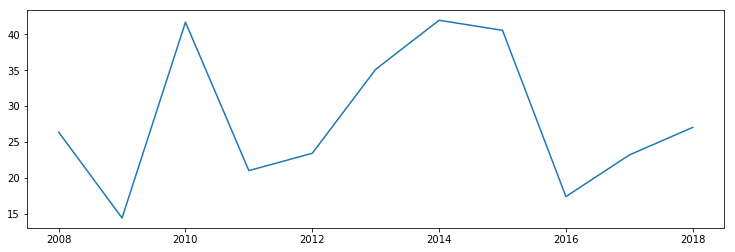

In [97]:
plt.figure(figsize=(12.5,4))
plt.plot(range(2008,2019), scores)
print("")
print("Mean test scores", np.mean(scores))
print("Mean validation scores", np.mean(val_scores))

In [98]:
rows = []
for model in best_models:
    rows.append(model.get_params())
pd.DataFrame(rows).describe()

,base_score,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,min_child_weight,n_estimators,n_jobs,random_state,reg_alpha,reg_lambda,scale_pos_weight,subsample
count,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0,12.0,12.000000,12.000000,12.000000,12.000000
mean,0.5,0.289259,0.395870,0.637277,0.064568,0.013467,4.083333,4.083333,4.000000,512.500000,-1.0,0.0,1.380268,1.529673,0.995763,0.398995
std,0.0,0.197862,0.250293,0.346990,0.015071,0.007042,0.792961,0.792961,0.603023,201.066475,0.0,0.0,0.350751,0.398821,0.040837,0.119749
min,0.5,0.100000,0.100000,0.203878,0.040000,0.005473,3.000000,3.000000,3.000000,260.000000,-1.0,0.0,1.000000,1.000000,0.958982,0.124681
25%,0.5,0.199427,0.227099,0.237211,0.054229,0.008559,3.750000,4.000000,4.000000,371.500000,-1.0,0.0,1.094673,1.211962,0.971120,0.385284
50%,0.5,0.249554,0.374827,0.847130,0.063981,0.010993,4.000000,4.000000,4.000000,450.000000,-1.0,0.0,1.268240,1.460258,0.981784,0.415258
75%,0.5,0.293698,0.483211,0.907343,0.079155,0.018979,5.000000,4.000000,4.000000,746.250000,-1.0,0.0,1.626918,1.961180,1.018015,0.492374
max,0.5,0.835453,0.996784,1.000000,0.088646,0.026787,5.000000,6.000000,5.000000,812.000000,-1.0,0.0,2.000000,2.000000,1.099947,0.500000


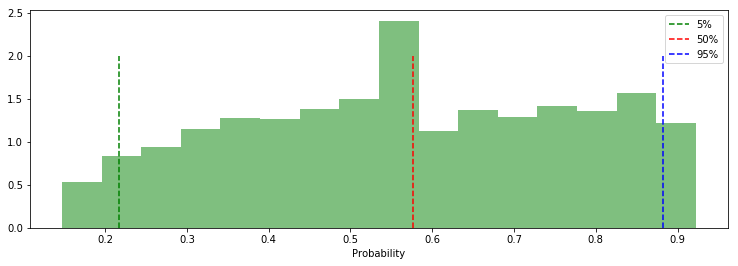

In [99]:
plt.figure(figsize=(12.5,4))
line_height = 2
data = Helpers().averagingModels(X, best_models)
_ = plt.hist(data, bins='auto', density=True, facecolor='green', alpha=0.5)

plt.vlines(np.percentile(data, 5), 0, line_height, linestyle="--", colors='green', label="5%")
plt.vlines(np.percentile(data, 50), 0, line_height, linestyle="--", colors='red', label="50%")
plt.vlines(np.percentile(data, 95), 0, line_height, linestyle="--", colors='blue', label="95%")
plt.xlabel('Probability')
plt.legend()

In [100]:
from helper_functions.functions import Helpers

features = Features().div_cols(X_list[0]).columns

imp = pd.DataFrame(data=Helpers().averagingImp(best_models),
             index=features,
             columns=['importance']).sort_values(by=['importance'], ascending=False)
print(imp.shape)
imp

(22, 1)


,importance
perc,0.064750
h_M_mean,0.054899
F_ph_pa,0.052593
F_nh_pa,0.052395
A_ph_pa,0.052125
h_perc,0.050332
A_nh_na,0.050219
F_ph_na,0.049267
A_nh_pa,0.048987
A_ph_na,0.048961


## Model Analysis

In [101]:
print(X.shape)
overall = []
for i in range(len(best_models)):
    season_scores = []
    for rnd in range(1,24):
        df = pd.DataFrame(np.c_[X_list[i],y_list[i]])
        y_new = df[df[0] == rnd][X.shape[1]].values
        x_new = df[df[0] == rnd].drop(X.shape[1], axis=1).values
        score = Helpers().afl_loss(y_new,best_models[i].predict_proba(Features().div_cols(x_new).values)[:,1])
        season_scores.append(score)
    overall.append(season_scores)

(2193, 18)


Text(0.5, 1.0, 'Average Cumulative Score')

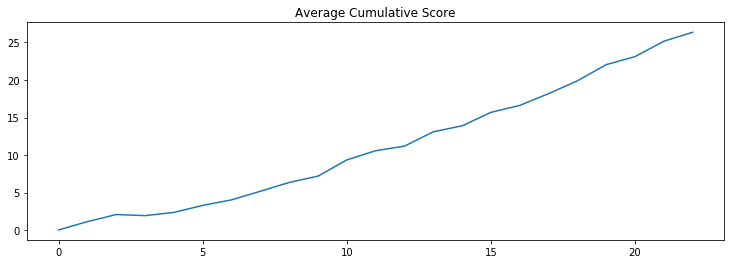

In [102]:
plt.figure(figsize=(12.5,4))
plt.plot(np.cumsum(np.array(np.matrix(np.array(overall)).mean(0)).flatten()))
plt.title('Average Cumulative Score')

In [103]:
data_A = np.load('model_A_scores.npy')
data_B = scores.copy()
print(np.sort(data_A))
print(np.sort(data_B))
print(np.mean(data_A))
print(np.mean(data_B))

[12.15956689 19.21382718 21.78991802 22.33412835 22.3417056  22.48145489
 27.46976236 32.39940932 39.98249465 40.45055324 43.80882099]
[14.38448882 17.35804333 20.98413516 23.16815276 23.40777682 26.35103317
 27.01713176 35.11992385 40.5567424  41.69870561 41.96587788]
27.67560377202703
28.36472832426896


In [104]:
import pymc3 as pm
# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    alpha_A = pm.Exponential('alpha_A', 1/10)
    beta_A = pm.Uniform('beta_A', lower=0, upper=1)
    alpha_B = pm.Exponential('alpha_B', 1/10)
    beta_B = pm.Uniform('beta_B', lower=0, upper=1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", alpha_A/beta_A - alpha_B/beta_B)
    
    obs_A = pm.Gamma("obs_A", alpha=alpha_A, beta=beta_A, observed=data_A)
    obs_B = pm.Gamma("obs_B", alpha=alpha_B, beta=beta_B, observed=data_B)
    
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta_B]
>Metropolis: [alpha_B]
>Metropolis: [beta_A]
>Metropolis: [alpha_A]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:14<00:00, 5163.91draws/s]
The number of effective samples is smaller than 10% for some parameters.


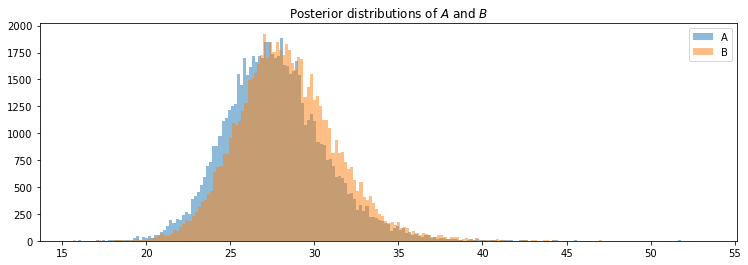

In [105]:
plt.figure(figsize=(12.5,4))
plt.title("Posterior distributions of $A$ and $B$")
plt.hist(burned_trace["alpha_A"]/burned_trace["beta_A"], bins='auto', histtype="stepfilled", alpha=0.5, label="A")
plt.hist(burned_trace["alpha_B"]/burned_trace["beta_B"], bins='auto', histtype="stepfilled", alpha=0.5, label="B")
plt.legend()

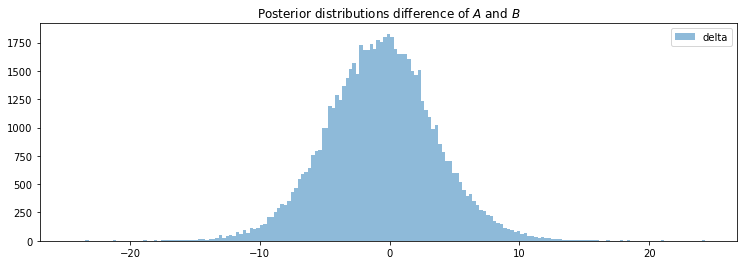

In [106]:
plt.figure(figsize=(12.5,4))
plt.title("Posterior distributions difference of $A$ and $B$")
plt.hist(burned_trace["delta"], bins='auto', histtype="stepfilled", alpha=0.5, label="delta")
plt.legend()

In [107]:
print("Probability model A is WORSE than model B: %.3f" % \
    np.mean(burned_trace["delta"] < 0))

print("Probability model A is BETTER than model B: %.3f" % \
    np.mean(burned_trace["delta"] > 0))

Probability model A is WORSE than model B: 0.568
Probability model A is BETTER than model B: 0.432


In [108]:
np.save('model_A_scores.npy', data_B)

## Save models

In [164]:
from joblib import dump
# dump(model, 'models/model.joblib') 
for i in range(len(best_models)):
    dump(best_models[i], 'models/model'+str(i)+'.joblib') 

## Load models

In [5]:
from joblib import load
# model = load('models2/model.joblib')
best_models = []
for i in range(11):
    best_models.append(load('models/model'+str(i)+'.joblib'))

## Scoring

In [11]:
from data_prep.web_scraping import Scrape

games = []
start = 179
for i in range(start,start+9):
    games.append(Scrape(mapping, proxyDict).scrape_game(i))
games

[['Essendon', 'Greater Western Sydney'],
 ['Geelong', 'Adelaide'],
 ['Hawthorn', 'West Coast'],
 ['Sydney', 'Gold Coast'],
 ['Collingwood', 'North Melbourne'],
 ['Port Adelaide', 'Western Bulldogs'],
 ['St Kilda', 'Richmond'],
 ['Brisbane Lions', 'Melbourne'],
 ['Fremantle', 'Carlton']]

In [43]:
from modelling.scoring import Scoring
scoring_df = Scoring(mapping, proxyDict, enc).score_data(games)
scoring = scoring_df.values

In [44]:
scoring_df

,Rnd,h_F_mean,h_F_std,h_A_mean,h_A_std,h_M_mean,h_M_std,h_R_mean,h_perc,a_F_mean,a_F_std,a_A_mean,a_A_std,a_M_mean,a_M_std,a_R_mean,a_perc,grnd,perc,R_mean,F_mean,A_mean,F_std,A_std,F_eng,A_eng
0,15.0,77.615385,26.464892,77.000000,22.226111,0.615385,22.226111,0.461538,1.007992,94.769231,29.974743,71.307692,19.569932,23.461538,19.569932,0.692308,1.329018,3.0,0.758449,0.666667,0.818994,1.079827,0.882906,1.135728,0.410044,1.917866
1,15.0,96.000000,20.795710,65.769231,16.053535,30.230769,16.053535,0.846154,1.459649,82.307692,18.685184,71.538462,17.989806,10.769231,17.989806,0.615385,1.150538,0.0,1.268667,1.375000,1.166355,0.919355,1.112952,0.892368,0.744649,1.528008
2,15.0,77.153846,10.683173,79.307692,21.123755,-2.153846,21.123755,0.384615,0.972842,82.769231,23.155507,77.923077,19.305087,4.846154,19.305087,0.692308,1.062192,29.0,0.915882,0.555556,0.932156,1.017769,0.461366,1.094207,0.627527,1.713321
3,15.0,77.923077,13.847863,84.538462,15.112987,-6.615385,15.112987,0.384615,0.921747,62.153846,11.373695,86.461538,21.770182,-24.307692,21.770182,0.230769,0.718861,47.0,1.282232,1.666667,1.253713,0.977758,1.217534,0.694206,0.871445,1.540414
4,15.0,91.230769,18.060385,72.230769,10.437756,19.000000,10.437756,0.769231,1.263046,82.384615,19.376983,88.923077,22.842139,-6.538462,22.842139,0.384615,0.926471,3.0,1.363288,2.000000,1.107376,0.812284,0.932054,0.456952,0.719037,1.251019
5,15.0,84.615385,20.242904,78.153846,19.708827,6.461538,19.708827,0.538462,1.082677,81.846154,15.225718,91.000000,23.706539,-9.153846,23.706539,0.384615,0.899408,12.0,1.203766,1.400000,1.033835,0.858833,1.329520,0.831367,0.663142,1.454267
6,15.0,73.153846,8.856516,87.692308,25.082585,-14.538462,25.082585,0.461538,0.834211,77.692308,20.066753,84.461538,24.487408,-6.769231,24.487408,0.538462,0.919854,0.0,0.906894,0.857143,0.941584,1.038251,0.441353,1.024305,0.657712,1.880392
7,15.0,89.230769,19.010741,82.538462,19.065133,6.692308,19.065133,0.615385,1.081081,71.000000,20.003846,90.230769,19.055199,-19.230769,19.055199,0.307692,0.786871,23.0,1.373898,2.000000,1.256771,0.914749,0.950354,1.000521,0.771616,1.427507
8,15.0,78.153846,26.267401,72.230769,14.613765,5.923077,14.613765,0.538462,1.082002,70.461538,19.696214,89.153846,23.549771,-18.692308,23.549771,0.153846,0.790336,12.0,1.369040,3.500000,1.109170,0.810181,1.333627,0.620548,0.575507,1.323767


In [45]:
def modelStats(X, models=[]):
    predictions = np.column_stack([
        model.predict_proba(X)[:,1] for model in models
    ])
    return [np.mean(predictions, axis=1), np.median(predictions, axis=1), np.std(predictions, axis=1), 
            np.max(predictions, axis=1), np.min(predictions, axis=1)]

arr = np.c_[ games, best_models[0].predict_proba(scoring)[:,1], modelStats(scoring,best_models)[0],
           modelStats(scoring,best_models)[1],modelStats(scoring,best_models)[2],
            modelStats(scoring,best_models)[3], modelStats(scoring,best_models)[4]] 
pd.DataFrame(arr,columns=['home','away', 'prob','prob_avg', 'prob_med', 'prob_std', 'prob_max', 'prob_min'])

,home,away,prob,prob_avg,prob_med,prob_std,prob_max,prob_min
0,Essendon,Greater Western Sydney,0.35965306,0.39950883,0.40438008,0.02247639,0.43206626,0.35965306
1,Geelong,Adelaide,0.75096005,0.70435375,0.7014636,0.025453229,0.75096005,0.65570873
2,Hawthorn,West Coast,0.4896788,0.48271286,0.48612964,0.021129737,0.52783877,0.44900233
3,Sydney,Gold Coast,0.712768,0.7175896,0.71849155,0.0219968,0.7500611,0.6852653
4,Collingwood,North Melbourne,0.81523836,0.811469,0.80422825,0.01695837,0.85069984,0.7968255
5,Port Adelaide,Western Bulldogs,0.80228096,0.80456,0.7954918,0.026110338,0.85854036,0.7704143
6,St Kilda,Richmond,0.56065,0.5104596,0.5117964,0.029953718,0.56065,0.46368793
7,Brisbane Lions,Melbourne,0.83282185,0.8109855,0.81390893,0.020589942,0.83950204,0.7728315
8,Fremantle,Carlton,0.77531374,0.82057697,0.8222264,0.019887477,0.8461107,0.77531374


## Scratch

In [6]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [7]:
team_df['Richmond',0]

,Rnd,T,Opponent,Scoring,F,Scoring,A,R,M,WDL,Venue,Crowd,Date
0,R1,A,Carlton,5.4 7.8 10.9 14.13,97,0.1 4.4 8.8 9.10,64,W,33,1-0-0,M.C.G.,85016,Thu 21-Mar-2019 7:25 PM
1,R2,H,Collingwood,2.2 6.3 9.4 10.6,66,3.2 7.3 12.4 17.8,110,L,-44,1-0-1,M.C.G.,70699,Thu 28-Mar-2019 7:20 PM
2,R3,A,Greater Western Sydney,3.6 5.10 9.14 10.16,76,2.4 8.7 13.10 19.11,125,L,-49,1-0-2,Showground,12697,Sat 06-Apr-2019 4:35 PM
3,R4,A,Port Adelaide,2.5 6.8 11.8 15.9,99,4.1 7.3 11.6 14.8,92,W,7,2-0-2,Adelaide Oval,38864,Sat 13-Apr-2019 4:05 PM
4,R5,H,Sydney,3.3 9.5 11.9 13.11,89,2.1 4.2 6.3 10.7,67,W,22,3-0-2,Docklands,40053,Sat 20-Apr-2019 7:25 PM
5,R6,H,Melbourne,3.1 5.4 7.9 12.13,85,4.1 4.2 5.5 6.6,42,W,43,4-0-2,M.C.G.,72704,Wed 24-Apr-2019 7:35 PM
6,R7,A,Western Bulldogs,3.2 4.6 7.7 7.10,52,2.5 6.7 12.8 15.9,99,L,-47,4-0-3,Docklands,36151,Sat 04-May-2019 7:25 PM
7,R8,A,Fremantle,4.3 7.4 13.8 17.9,111,3.2 5.3 8.11 12.14,86,W,25,5-0-3,Perth Stadium,42641,Sun 12-May-2019 3:20 PM
8,R9,H,Hawthorn,3.2 6.6 11.7 14.11,95,2.5 3.8 6.9 8.11,59,W,36,6-0-3,M.C.G.,64936,Sun 19-May-2019 3:20 PM
9,R10,H,Essendon,1.2 4.7 8.11 10.13,73,0.3 1.7 2.10 6.14,50,W,23,7-0-3,M.C.G.,80176,Sat 25-May-2019 7:25 PM
